In [7]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.checkpoint as C
import torchvision.transforms.functional as fn
import torchvision.transforms as T
import matplotlib.pyplot as plt
!pip install -q torchsummary
from torchvision import models
from torchsummary import summary

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')    
device

device(type='cuda')

In [56]:
train_path = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
ids = os.listdir(train_path)
os.makedirs('/kaggle/data_dir/',exist_ok=True)

In [15]:
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

In [ ]:
for i in ids:
    band15= np.load(f'{train_path}/{i}/band_15.npy')
    band14= np.load(f'{train_path}/{i}/band_14.npy')
    band11= np.load(f'{train_path}/{i}/band_11.npy')
    r= normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g= normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b= normalize_range(band14, _T11_BOUNDS)
    image = np.clip((np.stack([r,g,b],axis=2)),0,1)
    image = image[...,4]
    mask=np.load(f'{train_path}/{i}/human_pixel_masks.npy')
    directory = f'/kaggle/data_dir/{i}/'
    os.makedirs(directory, exist_ok=True)
    np.save(os.path.join(directory, 'false.npy'), image)
    np.save(os.path.join(directory, 'mask.npy'), mask)

In [9]:
class CustomDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.ids = os.listdir(self.path)
    def __len__(self):
        return len(self.ids)
    def __getitem__(self,idx):
        id = ids[idx]
        image = np.load(f'{self.path}/{id}/false.npy')
        mask = np.load(f'{self.path}/{id}/mask.npy')
        image = torch.from_numpy(image)
        image = torch.moveaxis(image,-1,0)
        mask = torch.from_numpy(mask)
        mask=torch.moveaxis(mask,-1,0)
        return image,mask.float()

In [11]:
train_dataset = CustomDataset('/kaggle/data_dir')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/data_dir'

In [10]:
train_dataloader = DataLoader(train_dataset,batch_size=64, shuffle=True)

NameError: name 'train_dataset' is not defined

In [ ]:
test_image , test_mask = next(iter(train_dataloader))
test_image = torch.moveaxis(test_image,1,-1)
test_mask = torch.moveaxis(test_mask,1,-1)
ax , fig = plt.subplots(1,2)
fig[0].imshow(test_image[2])
fig[1].imshow(test_mask[2])

In [ ]:
model = smp.Unet(encoder_name='resnet34',encoder_weights='imagenet',in_channels=3,classes=1)
model.to(device)

In [ ]:
summary(model,(3,256,256))

In [ ]:
def Dice_loss(pred, mask):
    
    smooth = 1e-6  # Smoothing factor to avoid division by zero
        
    intersection = torch.sum(pred * mask)
    union = torch.sum(pred) + torch.sum(mask)

    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = 1.0 - dice_coefficient

    return dice_loss

    

In [ ]:
os.makedirs('/kaggle/working/savedmodel')

In [ ]:
learning_rate = 0.005
losses = []
epochs=40
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience = 4, factor = 0.31622776601, verbose = True)
best_score = 0
best_dice_epoch = 0
for epoch in range(epochs):
    batch_dice_score = 0
    net_dice_loss = 0
    if(epoch - best_dice_epoch > 10):
        print(f'early stopped due to no improvement in last 10 epochs')
        torch.save(model.state_dict(),f'/kaggle/working/savedmodel/last_run_epoch.pt')
        break
    for image , mask in tqdm(train_dataloader):
        image,mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        pred = model(image)
        loss = Dice_loss(pred,mask)
        loss.backward()
        optimizer.step()
        batch_dice_score += (1-loss)
        net_dice_loss +=loss
    losses.append(net_dice_loss)
    print(f'at {epoch}th the dice loss is {net_dice_loss}')
    if(best_score<batch_dice_score):
        torch.save(model.state_dict(),f'/kaggle/working/savedmodel/{epoch}th_epoch.pt')
        torch.save(model,f'{epoch}th_model.pt')
        best_score = batch_dice_score
        best_dice_epoch = epoch

In [ ]:
for  i in range(len(losses)):
    losses[i] = losses[i].detach().to('cpu').to(dtype=torch.uint8)

In [ ]:
plt.plot(losses)

In [1]:
import torch

In [5]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')
device

device(type='cuda')

In [25]:
model = torch.load('/kaggle/input/contrails-segmentation-best-run-version-1/19th_model.pt')

In [26]:
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [28]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [57]:
band15= np.load(f'{train_path}/1000216489776414077/band_15.npy')
band14= np.load(f'{train_path}/1000216489776414077/band_14.npy')
band11= np.load(f'{train_path}/1000216489776414077/band_11.npy')
r= normalize_range(band15 - band14, _TDIFF_BOUNDS)
g= normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
b= normalize_range(band14, _T11_BOUNDS)
image = np.clip((np.stack([r,g,b],axis=2)),0,1)
image = image[...,4]

In [58]:
image = torch.from_numpy(image)
image = torch.moveaxis(image,-1,0)
image = torch.unsqueeze(image,dim=0)

In [36]:
image.shape

torch.Size([1, 3, 256, 256])

In [59]:
mask = model.forward(image.to(device))

In [60]:
mask = mask.to('cpu')

In [40]:
print(mask)

tensor([[[[0.2016, 0.3885, 0.4523,  ..., 0.4476, 0.3662, 0.2029],
          [0.3986, 0.6230, 0.7319,  ..., 0.7293, 0.6332, 0.3538],
          [0.4545, 0.7159, 0.8059,  ..., 0.8034, 0.7165, 0.4174],
          ...,
          [0.4397, 0.7001, 0.7983,  ..., 0.8012, 0.7099, 0.4125],
          [0.3666, 0.6058, 0.7064,  ..., 0.7137, 0.6094, 0.3529],
          [0.1804, 0.2907, 0.3707,  ..., 0.3792, 0.3012, 0.1435]]]],
       grad_fn=<ToCopyBackward0>)


In [43]:
print(mask)

tensor([[[[0.2016, 0.3885, 0.4523,  ..., 0.4476, 0.3662, 0.2029],
          [0.3986, 0.6230, 0.7319,  ..., 0.7293, 0.6332, 0.3538],
          [0.4545, 0.7159, 0.8059,  ..., 0.8034, 0.7165, 0.4174],
          ...,
          [0.4397, 0.7001, 0.7983,  ..., 0.8012, 0.7099, 0.4125],
          [0.3666, 0.6058, 0.7064,  ..., 0.7137, 0.6094, 0.3529],
          [0.1804, 0.2907, 0.3707,  ..., 0.3792, 0.3012, 0.1435]]]],
       grad_fn=<ToCopyBackward0>)


In [61]:
mask = torch.squeeze(mask,dim=0)

In [62]:
mask = mask.detach()

In [63]:
mask = mask.numpy()

In [49]:
mask.shape

(1, 256, 256)

In [64]:
mask = np.squeeze(mask,axis=0)

In [55]:
print(mask)

[[0.20156595 0.38852352 0.4523003  ... 0.44755104 0.3662102  0.20293844]
 [0.3986192  0.6229939  0.73188615 ... 0.7293183  0.6331523  0.35378066]
 [0.4544769  0.7158534  0.805866   ... 0.8034211  0.7164916  0.41736653]
 ...
 [0.43974128 0.70014846 0.7983001  ... 0.8011758  0.7098806  0.41248873]
 [0.36664146 0.6057506  0.70641625 ... 0.71371967 0.60937524 0.35294357]
 [0.1803558  0.29071525 0.3706621  ... 0.37921742 0.30119509 0.14346677]]


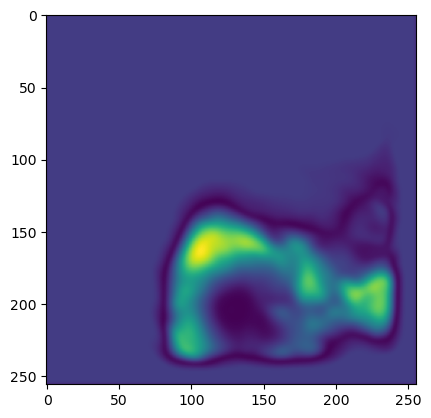

In [65]:
plt.imshow(mask)

In [68]:
arr = np.load('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train/1000216489776414077/human_pixel_masks.npy')

In [80]:
image = np.transpose(image,(1,2,0))
image.shape

(256, 256, 3)

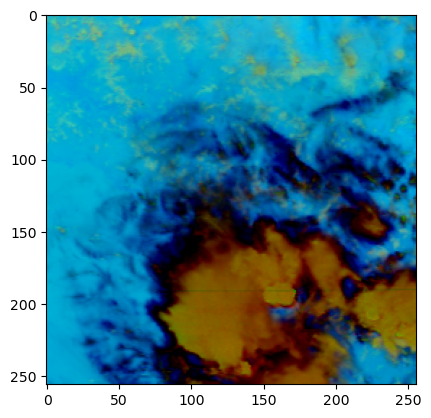

In [81]:
plt.imshow(image)